In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import optax
import jax
from jax import vmap, jit, lax
import jax.numpy as jnp
from evosax.strategies.open_nes import init_strategy, ask, tell
from evosax.utils import z_score_fitness, rank_shaped_fitness


def quadratic_fitness(w):
    fit = jnp.sum(jnp.square(w - jnp.array([0.5, 0.1, -0.3])))
    return fit

batch_fitness = vmap(quadratic_fitness, 0)

population_size = 50  
sigma_init = 0.1
lrate = 0.01
rng = jax.random.PRNGKey(0)

In [2]:
n_dim = 3
mean_init = jnp.zeros((n_dim, ))

opt = optax.adam(lrate)
opt_state = opt.init(mean_init)

In [3]:
rng = jax.random.PRNGKey(0)
num_generations = 200
params, memory = init_strategy(lrate, mean_init, sigma_init,
                               population_size)
fit = []
for g in range(num_generations):
    # Explicitly handle random number generation
    rng, rng_input = jax.random.split(rng)

    # Ask for the next generation population to test
    x, memory = ask(rng_input, params, memory)
    # Evaluate the fitness of the generation members
    #fitness = batch_rosenbrock(x, 1, 100) 
    fitness = batch_fitness(x)
    fit.append(fitness.min())
    fitness = z_score_fitness(fitness)
    #x, fitness = rank_shaped_fitness(x, fitness)
    # Tell/Update the CMA-ES with newest data points
    memory, opt_state = tell(x, fitness, params, memory, opt_state)
    

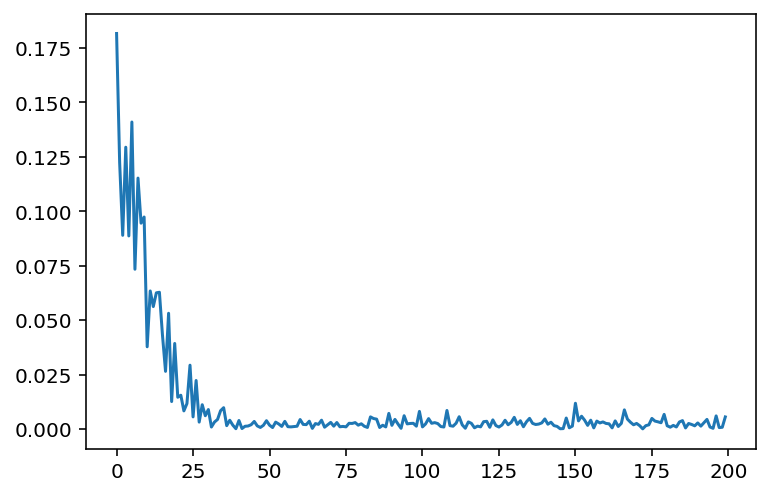

In [4]:
import matplotlib.pyplot as plt
plt.plot(fit)

# MNIST CNN in Haiku example

In [5]:
import haiku as hk
import tensorflow_datasets as tfds
from evosax.utils import (get_total_params, get_network_shapes,
                          flat_to_network)

In [6]:
def load_dataset(split, is_training, batch_size):
    """Loads the dataset as a generator of batches."""
    ds = tfds.load("mnist:3.*.*", split=split).cache().repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    return iter(tfds.as_numpy(ds))

# Make MNIST datasets.
train = load_dataset("train", is_training=True, batch_size=128)
train_eval = load_dataset("train", is_training=False, batch_size=10000)
test_eval = load_dataset("test", is_training=False, batch_size=10000)

In [10]:
class MNIST_CNN(hk.Module):
    def __init__(self, output_channels=(8, 16, 16), strides=(2, 1, 2)):   
        super().__init__()
        self.output_channels = output_channels
        self.strides = strides

    def __call__(self, batch):
        """Classifies images as real or fake."""
        x = batch["image"].astype(jnp.float32) / 255.
        for output_channels, stride in zip(self.output_channels, self.strides):
            x = hk.Conv2D(output_channels=output_channels,
                        kernel_shape=[5, 5],
                        stride=stride,
                        padding="SAME")(x)
            x = jax.nn.leaky_relu(x, negative_slope=0.2)
        x = hk.Flatten()(x)    
        # We have two classes: 0 = input is fake, 1 = input is real.
        logits = hk.Linear(10)(x)
        return logits
    
# Evaluation metrics (classification accuracy + cross-entropy loss).
@jax.jit
def accuracy(params, batch):
    predictions = net.apply(params, batch)
    return jnp.mean(jnp.argmax(predictions, axis=-1) == batch["label"])


@jax.jit
def loss(params, batch, w_decay=1e-4):
    """Compute the loss of the network, including L2."""
    logits = net.apply(params, batch)
    labels = jax.nn.one_hot(batch["label"], 10)

    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]

    return softmax_xent + w_decay * l2_loss

# Initialize transform and network size
rng = jax.random.PRNGKey(0)
net = hk.without_apply_rng(hk.transform(lambda *args: MNIST_CNN()(*args)))
params = net.init(jax.random.PRNGKey(42), next(train))

In [11]:
def reshape_and_eval(x, network_shapes):
    """ Perform both parameter reshaping and evaluation in one go. """
    nn = flat_to_network(x, network_shapes)
    out = loss(nn, next(train))
    return out

In [22]:
total_no_params = get_total_params(params)
network_shapes = get_network_shapes(params)

print(total_no_params)
print(network_shapes)

flat_params = 0.001*jax.random.normal(rng, shape=(total_no_params, ))
reshape_and_eval(flat_params, network_shapes)

17690
FrozenDict({
    mnist_cnn/conv2_d: {
        w: (5, 5, 1, 8),
        b: (8,),
    },
    mnist_cnn/conv2_d_1: {
        w: (5, 5, 8, 16),
        b: (16,),
    },
    mnist_cnn/conv2_d_2: {
        w: (5, 5, 16, 16),
        b: (16,),
    },
    mnist_cnn/linear: {
        w: (784, 10),
        b: (10,),
    },
})


DeviceArray(2.302532, dtype=float32)

In [23]:
pop_size = 10
scale = 1e-02
batch_fitness = vmap(reshape_and_eval, in_axes=(0, None))
batch_params = scale*jax.random.normal(rng, shape=(pop_size,
                                                   total_no_params))
batch_fitness(batch_params, network_shapes)
# Get fitness for a set of network parametrizations
#flat_params = jax.random.normal(rng, shape=(total_no_params,))
#fill_up = jit(flat_to_network, static_argnums=(1, 2))
#nn = fill_up(flat_params, network_shapes, param_idx_list)
#reshape_and_eval(flat_params, network_shapes, param_idx_list)

# Will be replaced by ES ask proposals
# Jitting doesnt work with loop over dicts
# But it does work when using plain integers
# Precompute list of indices into flat vector?

DeviceArray([2.3026183, 2.3018358, 2.302478 , 2.2999434, 2.3041456,
             2.3031795, 2.3026679, 2.303886 , 2.3019664, 2.3039048],            dtype=float32)

In [ ]:
# Run Open-NES
num_generations = 10
population_size = 10
mean_init = jnp.zeros((total_no_params, ))

opt = optax.adam(lrate)
opt_state = opt.init(mean_init)

params, memory = init_strategy(lrate, mean_init, sigma_init,
                               population_size)
fit = []
for g in range(num_generations):
    # Explicitly handle random number generation
    rng, rng_input = jax.random.split(rng)

    # Ask for the next generation population to test
    x, memory = ask(rng_input, params, memory)
    # Evaluate the fitness of the generation members
    #fitness = batch_rosenbrock(x, 1, 100) 
    fitness = batch_fitness(x, network_shapes)
    fit.append(fitness.min())
    print(fit[-1])
    fitness = z_score_fitness(fitness)
    # x, fitness = rank_shaped_fitness(x, fitness)
    # Tell/Update the CMA-ES with newest data points
    memory, opt_state = tell(x, fitness, params, memory, opt_state)
    

# Explicit Fisher for non-diagonal MVN case

In [ ]:
# Old snippets with explicit Fisher inverse - Problem with vector outer product
# and rank deficiency when trying to do inverse!
def tell_nas_strategy(x, fitness, params, memory, opt, opt_state):
    """ Update the surrogate ES model. """
    memory["generation"] = memory["generation"] + 1

    # Get REINFORCE-style gradient for each sample
    log_grads = batch_grad_logpdf(x, memory["search_params"])
    # Weight grads by fitness/fitness shaping-rank + Fischer Estimator
    fischer_weighted_grads = {}
    for k, l_grad in log_grads.items():
        # Weight grads by fitness
        weighted_log_grads = jnp.mean(fitness[:, None, None]*l_grad, axis=0)
        # Compute unweighted mean for Fischer approximation
        mean_log_grads = jnp.mean(l_grad, axis=0)
        print(mean_log_grads.shape)
        outer_product = mean_log_grads @ mean_log_grads.T
        # Compute the Fischer matrix approximation
        fischer_inverse = jnp.linalg.inv(outer_product)
        fischer_weighted_grads[k] = (-1.*fischer_inverse @ weighted_log_grads)
    # Perform natural gradient update using optax - Flip grad sign for min!
    updates, opt_state = opt.update(fischer_weighted_grads, opt_state)
    new_params = optax.apply_updates(memory["search_params"], updates)
    memory["search_params"] = new_params
    return memory, opt_state


def grad_gauss_logpdf(x, params):
    """ Obtain grad log pi for multivariate Gaussian case. """
    def gauss_logpdf(x, params):
        return logpdf(x, params["mean"].squeeze(), params["C"])
    return grad(gauss_logpdf, argnums=(1))(x, params)

def loss_logpdf(x, weight, params):
    weighted_logprobs = batch_grad_logpdf(x, weight, params)
    return - weighted_logprobs.mean()


def weighted_gauss_logpdf(x, weight, params):
    """ Obtain grad log pi for multivariate Gaussian case. """
    def gauss_logpdf(x, params):
        return logpdf(x, params["mean"].squeeze(), params["C"])
    return gauss_logpdf(x, params) * weight


batch_grad_logpdf = vmap(weighted_gauss_logpdf, in_axes=(0, 0, None))